<a href="https://colab.research.google.com/github/thedarredondo/data-science-fundamentals/blob/main/Unit6/Unit6NotesAK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm
import matplotlib.pyplot as plt

# Unit 6: Multiple Generalized Linear Regression

Last unit we learned how to predict a probalistic process using a different probablistic process--like using temperature to predict bike rentals.

This unit, we'll see what happens when we allow ourselves to use multiple predictors, instead of just one. This is more powerful, but also more challenging; we'll now have to decide what and how many predictors to use. We'll learn some new techniques and concepts to help us choose predictors and whole models, and we'll even use new libraries, bambi and kulprit, to make the model creation and checking process faster and more streamlined.

Here's what we'll cover, and the order we'll cover it in:
1. Multiple Linear Regression with pymc and model comparison
2. Regression with Bambi
3. Balancing Underfitting with Overfitting
  - Variable selection (possibly with kulprit)
5. Recreating preivous examples in Bambi
6. The ways we can create a model with categorical and continuous predictors

Let's dive in.

We'll spend most of this unit with the bikes data set, so that we can focus on the new concepts. I'll then throw in examples with other data sets once we've introduced all the new things

In [6]:
bikes = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/bikes.csv')

In [3]:
bikes

,rented,hour,temperature,humidity,windspeed,weekday
0,16,0,3.28,0.81,0.0000,6
1,3,5,-0.48,0.47,0.2836,1
2,115,9,2.34,0.37,0.3284,3
3,73,13,1.40,0.37,0.2836,5
4,82,15,2.34,0.35,0.3582,0
...,...,...,...,...,...,...
343,90,9,4.22,0.48,0.3881,6
344,135,12,5.16,0.56,0.0896,1
345,13,15,4.22,0.87,0.3582,3
346,271,17,3.28,0.60,0.1343,5


## Multiple Linear Regression with PyMC + Model Comparison with LOO

We will only use PyMC for multiple linear regression briefly. This is because multiple linear regression requires more plotting than simple linear regression, and bambi has some nice features for quickly and easily generating those plots.

We will use this oppurtunity to inroduce a new way to compare the performance of models, elpd_loo. This new method gives us a nice one number summary of which model is better, which is a useful tool to have when our models get two multidimensional to easily parse.

You've already seen the bikes model with temperature predicting rented. The model below is almost exactly the same.

In [32]:
#nbb stands for negative binomial bike model
with pm.Model() as model_nbb:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)

    #the linear part of our model,
    #but with a twist:
    #our line is exponentiated, in order to make our all our values positive
    μ = pm.Deterministic("μ", pm.math.exp(α + β * bikes.temperature))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=bikes.rented)

    #we need the log likelihood for model comparison later
    idata_nbb = pm.sample(idata_kwargs={"log_likelihood":True})

In [33]:
pm.sample_posterior_predictive(idata_nbb, model = model_nbb, extend_inferencedata=True)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

The model below is almost exactly the same.

In [34]:
#mlb stands for multiple linear bikes
with pm.Model() as model_mlb:

    #priors on the linear part of the model
    α = pm.Normal("α", mu=0, sigma=1)
    β0 = pm.Normal("β0", mu=0, sigma=10)
    β1 = pm.Normal("β1", mu=0, sigma=10)

    #linear part of the model
    μ = pm.Deterministic("μ", pm.math.exp(α + β0 * bikes.temperature + β1 * bikes.hour))

    #prior for the standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y = pm.NegativeBinomial("y", mu=μ, alpha=σ, observed=bikes.rented)

    #we need the log likelihood for model comparison later
    idata_mlb = pm.sample(idata_kwargs={"log_likelihood":True})

In [35]:
pm.sample_posterior_predictive(idata_mlb, model = model_mlb, extend_inferencedata=True)

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

**Task1**:

Looking only at the code, what's the difference between model\_nbb and model\_mlb?

**Answer1**:

There is a second predictor, bikes.hour, and a second slope to go along with it.

Let's compare the two models' preformance using a ppc

<Axes: xlabel='y / y'>

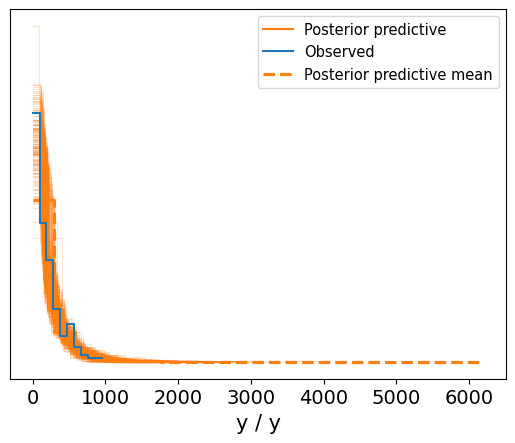

In [36]:
az.plot_ppc(idata_nbb, num_pp_samples=200, colors=["C1", "C0", "C1"])

<Axes: xlabel='y / y'>

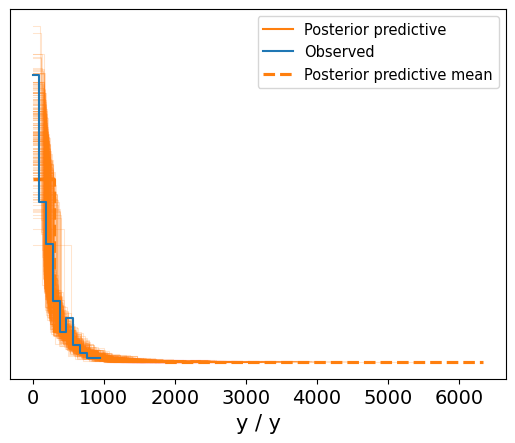

In [37]:
az.plot_ppc(idata_mlb, num_pp_samples=200, colors=["C1", "C0", "C1"])

**Task2**:

Describe any differences you can see.

**Answer2**:

model_mlb seems like its doing a little better predicting low bike count values, but I can't really tell

Hopefully you're wondering if there is another way to compare these two models.

And there is!

The method is called Pareto Smoothed Importance Sampling Leave-One-Out Cross-Validation, which estimates the Expected Log-Pointwise-predictive Density.

We abbreviate all that with ELPD$_{LOO-CV}$, or ELPD$_{LOO}$, or even just LOO.

As the long full name implies, there are a lot of advanced, fancy tricks applied to the posterior to calculate LOO.

The important things to know:
- a more positive elpd_loo is better. Since elpd_loo is essentially always negative, this means we pick the smallest magnitude negative number.
- the standard error (SE), sorta like the standard deviation, of elpd_loo helps tell us whether two models are significantly different than one another in terms of performance.
- There's something called a Pareto k diagnostic that tells us whether there were too many influential points for elpd_loo to be effective.



Let's look at the k diagnostic for the multiple linear model.

In [26]:
az.loo(idata_mlb)

<ipython-input-26-36315e66ff89>:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  az.loo(idata_mlb)


Computed from 2000 posterior samples and 348 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -2124.37    23.36
p_loo        4.65        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      348  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

All 348 values in the bikes data set have a small enough influence that we can almost completely trust elpd_loo's recommendation.

We also get the value of elpd_loo, and its standard error. But these are useless without another model to compare them too.

We do have another model to compare though! And arviz has some nice functions that will make the comparison trivial.

In [38]:
#cmp_df stands for compare dataframe
cmp_df = az.compare( {"multi_lin":idata_mlb,"single_lin":idata_nbb} )

#0 is the best rank; we want a lower elpd_loo
cmp_df

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi_lin,0,-2124.225868,4.485581,0.000000,0.903435,23.423618,0.000000,False,log
single_lin,1,-2153.170036,2.745116,28.944169,0.096565,19.803057,8.227043,False,log


elpd_loo and se are easier to understand using the graph below.

The other relevant entries are warning, which just needs to say False--False means our k diagnostic was good enough. The other interesting entry is weight. This can be used to average the models being compared, using the following code:

```
idata_w = az.weight_predictions([idata_mlb,idata_nbb], weights=[0.903435, 0.096565])
```



Let's say we don't want to combine the models though, but choose between them. Then its often easier to graph the above table, then make a decision.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

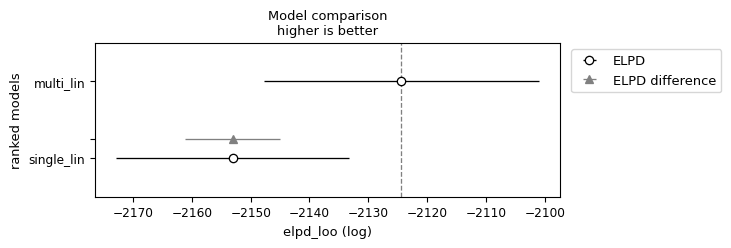

In [29]:
az.plot_compare(cmp_df)

**Task3**:

Using the model comparion table, which model would you pick? Why?

**Answer3**:

I'd probably pick the multiple linear model, especially if I needed to pick just one, and do no model averaging or combining.

But the overlapping standard error bars means that either model will perform similarly for predictive purposes. There isn't a clear winner between the two.

## Bambi is Best
For (generalized) linear models, anyway.

Bambi is library for building bayesian (generalized) linear models.

Here are the two main two reasons to love bambi:

- by auto assigning normal and half normal priors with mean 0 and sd 1, bambi models are fast to write and read.
- it has built in methods for plotting the posterior means and posterior predictive distribution. No more giant blocks of code to create plots for linear models!

Here are the two main reasons to be cautious with bambi:

- it only works with (generalized) linear models. As in, using bambi means that we are assuming some type of linear model.
- bambi auto assigns normal and half normal priors with a mean of 0 and sd of 1. This isn't that big a deal, since there's a quick way to feed the priors we want into bambi. But its easy to get lazy with bambi, which is fine, until it isn't.

Colab also doesn't have bambi preinstalled, so we need to install it each time will pull up colab.

We will also need to install the latest version of xarray, since bambi relies on its latest features.

Note that you may get prompted to restart the session, especially if you've already run pymc and/or arviz. Go ahead and do so, if prompted.

In [1]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-0h4a0qqs
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-0h4a0qqs
  Resolved https://github.com/pydata/xarray.git to commit 95e67b6dcaae357e8c5059757299d3605e155d1f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for xarray: filename=xarray-2024.6.1.dev67+g95e67b6d-py3-none-any.whl size=1177230 sha256=1fe4ed8bfb5543043e5eb5b5d2a76ba533178809a80afdc3909f6144862c98d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-psn_mvdt/wheels/3a/ec/c0/1cda725917279b6beba2a020d6ccddfee2176b25648f4fcad8
Successfully built xarray
  Attempting uninstall: xarray
    Found existing installation: xarray 2023.7.0
    Uninstalling xarray-2023.7.0:
      Successfully uninstalled xarray-2023.7.0


In [2]:
import xarray as xr

In [2]:
!pip install bambi

In [4]:
import bambi as bmb

In [5]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

### Linear Bikes + Regularizing Priors

Let's start by remaking the two bike models from earlier in the unit, but with bambi.

We'll also discuss the concept of regularizing priors; specifically, we'll see the the weakly informative priors bambi defaults too oftenn work great in practice.

#### Bambi bikes (1 predictor)
We'll start with the single variable model.

In [16]:
#we put the priors that aren't normal or half normal with mean 0 and sigma 1
#in a dict
priors ={"temperature" : bmb.Prior("Normal", mu=0,sigma=10), "alpha" : bmb.Prior("HalfNormal",sigma=10)}

#This creates a skeleton of the model; it hasn't run MCMC or created a posterior yet
model_nbb_bmb = bmb.Model("rented ~ temperature", bikes, family = "negativebinomial", priors=priors)

In [17]:
model_nbb_bmb

       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 2.5)
            temperature ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            alpha ~ HalfNormal(sigma: 10.0)

The 'family' argument in bmb.Model() is what determines both our likelihood and our link function. Bambi has default link functions that work well with families of likelihoods. Note the mu = log(x) is the same as exp(mu)=x.

Also notice that defining the model only takes two lines of code, and we only need one more to make the model it self.

In [38]:
#this is bambi's equivalent of pm.sample()
idata_nbb_bmb = model_nbb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

Two more lines gives us a plot of the posterior mean.

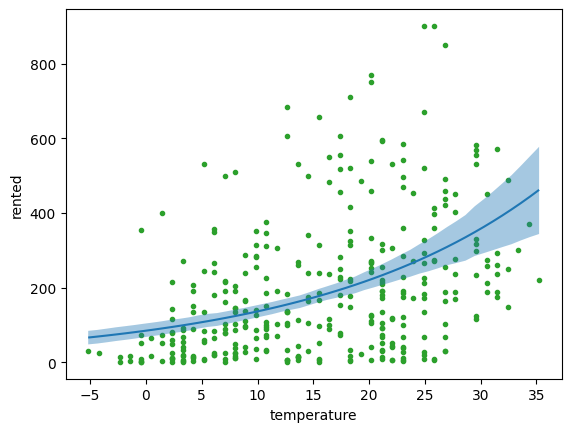

In [19]:
bmb.interpret.plot_predictions(model_nbb_bmb, idata_nbb_bmb, "temperature")
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

A final two lines give us the posterior predictive distribution.

In both graphs, the shaded blue area is a 94% HDI. You can change this by using the prob argument in the plot_predictions method.

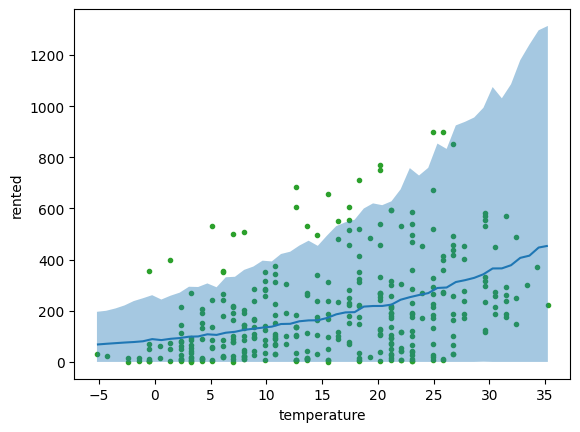

In [20]:
bmb.interpret.plot_predictions(model_nbb_bmb, idata_nbb_bmb, "temperature", pps=True)
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

#### Regularizing Priors (weakly informative priors)

We do not have to specify priors get a bambi model to run; bambi has a routine to determine the priors based off the raw data. Remember, that's the same strategy I told you to employ when you needed to specify prior(s) for which you had no context.

So, if you're handed data you know next to nothing about, you can safely selected a likelihood, and fire the model up.

But if you do have an understanding of the context, your final model should reflect your knowledge in its priors.

In [39]:
#notice that the priors argument isn't specified
model_nbb_bmb_regpriors = bmb.Model("rented ~ temperature", bikes, family = "negativebinomial")
idata_nbb_bmb_regpriors = model_nbb_bmb_regpriors.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

If you do let bambi select priors for you, then you must print out the model, to see what it selected. That way, you can check if its selections jive with your inuition.

In [26]:
model_nbb_bmb_regpriors

       Formula: rented ~ temperature
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 4.9184)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Let's see the posterior mean and posterior predictive.

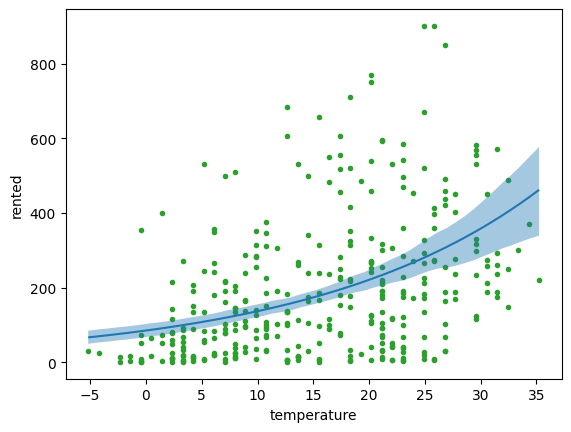

In [27]:
bmb.interpret.plot_predictions(model_nbb_bmb_regpriors, idata_nbb_bmb_regpriors, "temperature")
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

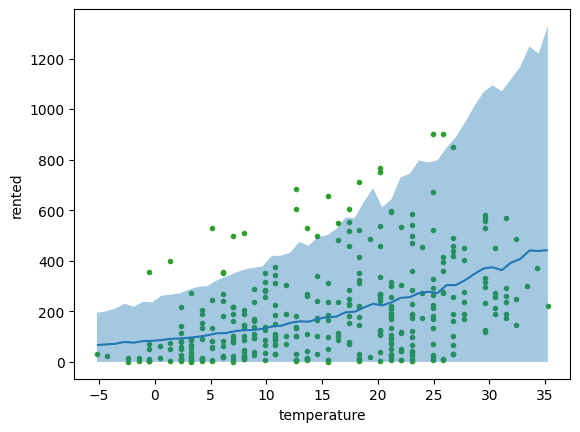

In [28]:
bmb.interpret.plot_predictions(model_nbb_bmb_regpriors, idata_nbb_bmb_regpriors, "temperature", pps = True)
plt.plot(bikes.temperature, bikes.rented, "C2.", zorder=-3)

**Task4**:

Are their any significant differences in the graphs of model_nbb_bmb and model_nbb_regpriors?

Why or why not?

**Answer4**:

There are basically no differences. Two reasons:
- The priors we specified were not that different from the ones bambi chose.
- Even if they had been that different, there's enough data to overwhelm most reasonable priors. We'd need a strong set of priors to affect a model with over 300 data points. Remember, as our data grows to infinity, all models, regardless of prior converge.*

*unless your prior is 0 or 1, or something equally asinine.

#### Bambi bikes (multiple predictors)

Now that we know what a regularings prior is, and why they're often good enough let's recreate the model with both temperature and hour.

And since I was using the data to create my priors anyway, I let bambi choose my priors.

In [40]:
model_mlb_bmb = bmb.Model("rented ~ temperature + hour", bikes, family="negativebinomial")
idata_mlb_bmb = model_mlb_bmb.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

I need to print the model, so I can see what priors bambi went with.

In [14]:
model_mlb_bmb

       Formula: rented ~ temperature + hour
        Family: negativebinomial
          Link: mu = log
  Observations: 348
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 6.4428)
            temperature ~ Normal(mu: 0.0, sigma: 0.2741)
            hour ~ Normal(mu: 0.0, sigma: 0.3615)
        
        Auxiliary parameters
            alpha ~ HalfCauchy(beta: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Let's visualize the model, so we can actually see what it suggests.

(<Figure size 640x480 with 24 Axes>,
 array([[<Axes: title={'center': 'hour = 0'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 1'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 2'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 3'}, xlabel='temperature', ylabel='rented'>],
        [<Axes: title={'center': 'hour = 4'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 5'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 6'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 7'}, xlabel='temperature', ylabel='rented'>],
        [<Axes: title={'center': 'hour = 8'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 9'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 10'}, xlabel='temperature', ylabel='rented'>,
         <Axes

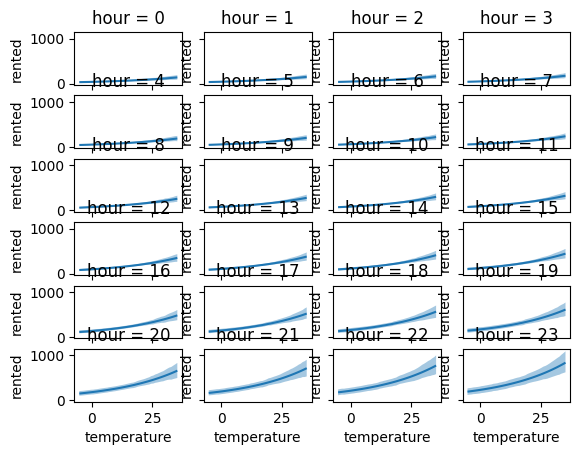

In [29]:
bmb.interpret.plot_predictions(model_mlb_bmb, idata_mlb_bmb, ["temperature", "hour"],
                               subplot_kwargs={"group":None, "panel":"hour"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True})

**Task5**:

Describe the relationship between the slope of temperature and the hour of the day, in model_mlb_bmb.

**Answer5**:

The slope of temerature increases as the hour increases. Additionally, the variance of the mean seems to increase as hour increases.

This is more obvious if you plot the posterior predictive distribution.

(<Figure size 640x480 with 24 Axes>,
 array([[<Axes: title={'center': 'hour = 0'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 1'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 2'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 3'}, xlabel='temperature', ylabel='rented'>],
        [<Axes: title={'center': 'hour = 4'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 5'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 6'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 7'}, xlabel='temperature', ylabel='rented'>],
        [<Axes: title={'center': 'hour = 8'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 9'}, xlabel='temperature', ylabel='rented'>,
         <Axes: title={'center': 'hour = 10'}, xlabel='temperature', ylabel='rented'>,
         <Axes

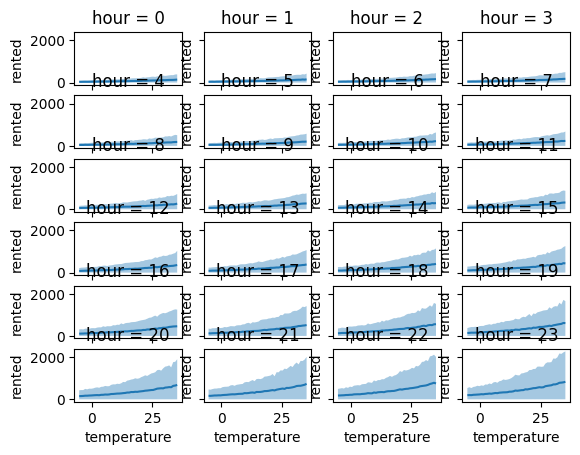

In [36]:
#ANSWER5 cont.
bmb.interpret.plot_predictions(model_mlb_bmb, idata_mlb_bmb, ["temperature", "hour"],
                               subplot_kwargs={"group":None, "panel":"hour"},
                               legend=False,
                               fig_kwargs={"sharey":True, "sharex":True},pps=True)

Bambi models are equally compatible with arivz, since they are running pymc under the hood. These means everything we learned about elpd_loo still applies.

In [42]:
cmp_df_bmb = az.compare( {"multi_lin":idata_mlb_bmb,"single_lin":idata_nbb_bmb} )
cmp_df_bmb

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
multi_lin,0,-2124.081644,4.425912,0.000000,0.932347,22.921586,0.000000,False,log
single_lin,1,-2153.215996,2.853375,29.134352,0.067653,19.497397,7.847803,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

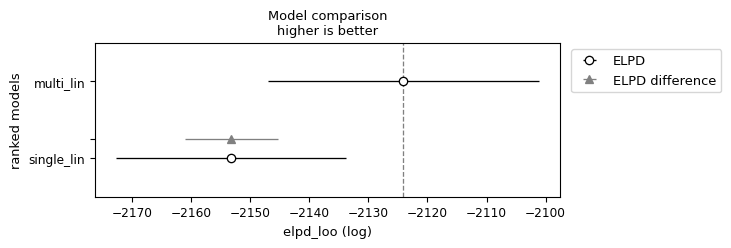

In [44]:
az.plot_compare(cmp_df_bmb)

## Underfiting versus Overfitting

When using multiple predictors, some logical questions arise:
- do we really need multiple predictors?
- if so, how many do we need?
- and which ones? Are some better than others? The same as others?

The process of answering those questions is known as variable selection.

**Task6**:

Given what you know and what we've learned thus far, how would you go about selecting which variables are best? If it helps, imagine we used all the variables in the bikes data set to predict rented.

**Answer6**:

I'd run models with combinations of all the variables, then throw them in arviz plot compare to see which ones had the lowest elpd_loo. Then I'd check the graphs of the top 1-3 models, to see if they were reasonable and made sense.

Kulprit is a library that makes variable selection--using the methods and skills we've learned--easier and more streamlined.

As has become usual, we need to restart the session, download kulprit, and then reimport everything.

In [1]:
!pip install git+https://github.com/pydata/xarray.git

  Cloning https://github.com/pydata/xarray.git to /tmp/pip-req-build-cl62l0un
  Running command git clone --filter=blob:none --quiet https://github.com/pydata/xarray.git /tmp/pip-req-build-cl62l0un
  Resolved https://github.com/pydata/xarray.git to commit 95e67b6dcaae357e8c5059757299d3605e155d1f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import xarray as xr

In [6]:
!pip install git+https://github.com/bambinos/kulprit.git

  Cloning https://github.com/bambinos/kulprit.git to /tmp/pip-req-build-b71lxahe
  Running command git clone --filter=blob:none --quiet https://github.com/bambinos/kulprit.git /tmp/pip-req-build-b71lxahe
  Resolved https://github.com/bambinos/kulprit.git to commit 9c16395a7e1989cfd1c5a301c34c3c658f09b339
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 500.9/500.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 MB 16.1 MB/s eta 0:00:00
  Created wheel for kulprit: filename=kulprit-0.2.0-py2.py3-none-any.whl size=21271 sha256=da5a587ffcb8293fa6c2d3e2589472413dd18a849e1cd2c839092aec19b71931
  Stored in directory: /tmp/pip-ephem-wheel-cache-cou795qk/wheels/ca/2b/c7/6510076d

In [ ]:
!pip install bambi

In [4]:
import kulprit as kpt

In [5]:
import bambi as bmb

In [6]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

Now that are libraries are ready to run, let's import the data we'll use

In [7]:
body = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/body_fat.csv')

In [6]:
body

,siri,age,weight,height,abdomen,thigh,wrist
0,12.3,23,70.1,172,85.2,59.0,17.1
1,6.1,22,78.8,184,83.0,58.7,18.2
2,25.3,22,70.0,168,87.9,59.6,16.6
3,10.4,26,84.0,184,86.4,60.1,18.2
4,28.7,24,83.8,181,100.0,63.2,17.7
...,...,...,...,...,...,...,...
246,11.0,70,61.0,170,83.6,49.6,18.5
247,33.6,72,91.4,177,105.0,59.6,20.1
248,29.3,72,84.9,168,111.5,60.3,18.0
249,26.0,72,86.7,179,101.3,56.0,19.8


The body data set has a measure of body fat percentage (siri), as well as several other measurments of other parts of a person's body, plus their age.

To see which variables predict siri best, we need to makea  model that includes all the variables.

We will take as a given that a normal likelihood, and bambi's choice of weakly informative priors, are good enough. Even if those assumptions later turn out to be bad, there's nothing wrong with starting with the defaults of bambi, and seeing what they get you

In [8]:
model_body = bmb.Model("siri ~ age + weight + height + abdomen + thigh + wrist", data=body)
idata_body = model_body.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

In [9]:
#always print and read the model description when you use the defaults
model_body

       Formula: siri ~ age + weight + height + abdomen + thigh + wrist
        Family: gaussian
          Link: mu = identity
  Observations: 251
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 19.0869, sigma: 777.7268)
            age ~ Normal(mu: 0.0, sigma: 1.648)
            weight ~ Normal(mu: 0.0, sigma: 1.6936)
            height ~ Normal(mu: 0.0, sigma: 3.1202)
            abdomen ~ Normal(mu: 0.0, sigma: 2.0371)
            thigh ~ Normal(mu: 0.0, sigma: 4.2)
            wrist ~ Normal(mu: 0.0, sigma: 22.7762)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 8.307)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Kulprit is going to perform something call Projection Predictive Inference (ppi). Basically, kulprit will use elpd_loo to find the subset of variables that
- contains the least number of variables
- also has a relatively low elpd_loo

We already know that elpd_loo is the standard for model comparison.

The reason we want the least number of variables has to do with overfitting. Any model can be made arbitraily better fit a given data set by adding more predictors.

The trick we need to pull off in modeling is to make a model that uses the given data to predict new data. For that reason, we usually have a bias agaisnt adding more variables. There's some advanced methods related to Gausissian processes (the next two units) that can avoid this problem though.

There is a second reason to avoid more variables: some of the variables might be giving the same information, or canceling each other out in some overly complicated way. This is always a potential problem, and means we will always want to perform variable selection

In [10]:
#this let's kulprit know which model and what posterior to use.
ppi = kpt.ProjectionPredictive(model_body,idata_body)

/usr/local/lib/python3.10/dist-packages/kulprit/projection/solver.py:37: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.num_chain = self.ref_idata.posterior.dims["chain"]


In [11]:
#run all the relevant submodels from the variables that we have.
ppi.search()

/usr/local/lib/python3.10/dist-packages/kulprit/projection/projector.py:191: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  chain=idata.posterior.dims["chain"],
/usr/local/lib/python3.10/dist-packages/kulprit/projection/projector.py:192: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  draw=idata.posterior.dims["draw"],
/usr/local/lib/python3.10/dist-packages/kulprit/projection/projector.py:191: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension n

In [12]:
#this tells me the name and comosition of the submodels,
#whose elpd_loo is vizualized in the next graph.
ppi

  0 siri ~ 1
  1 siri ~ abdomen
  2 siri ~ abdomen + weight
  3 siri ~ abdomen + weight + wrist
  4 siri ~ abdomen + weight + wrist + thigh
  5 siri ~ abdomen + weight + wrist + thigh + age
  6 siri ~ abdomen + weight + wrist + thigh + age + height

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.57 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:792: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.57 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:792: UserWarning: Estimat

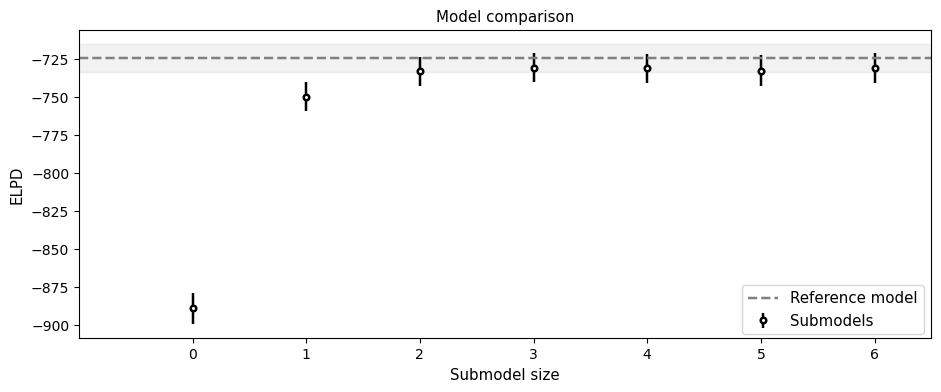

In [14]:
#comparison plot for the elpd_loo of all the submodels from above
cmp, ax = ppi.plot_compare(plot=True, figsize=(11, 4))

**Task7**:

Using the graphs above, determine which combination of variables is the best choice to make a model to predict the siri variable. Explicitly mention how you took underfitting and overfitting into account.

**Answer7**:

Need to Know:

We pick the first submodel whose mean elpd_loo value is also inside the shaded HDI of the reference model. Remember, the reference model is the one with all avaiable variables.

Selecting a model based on elpd_loo ensures we are doing our best to account for underfitting, or trying our best to be accurate.

Selecting a model with the smallest number of variables ensures we are doing our best to avoid overfitting, or letting our model get distriacted by unneccesary information.

Oh, and my code picked submodel 2, with variables abdomen, weight, and an intercept term.

----

Nice to Know:

Technically, the regulizing priors that bambi selected based on the data go a long way to making sure our predictions won't be too bad on new data, even if we include an extra few variables.

I'll say that again: weakly informative, or regularizing, priors do a lot to prevent overfitting. Priors are pretty much *the* way to help prevent overfitting.

In fact, having a bias towards models with less variables can itself be constructed as a prior. We're not going to make our preference that explicit, but the point is that we could.

The reason we won't make it that explicit, is that we want variable selection to be fluid. If we think an extra variable or two could capture information that happened to not be in this data set, then by all means, use your contextual knowledge to selcect a model with more variables.

And if we know that collection data on a three variable model is expensive or dangerous, then select an even smaller model.

When it comes to variable selection, elpd_loo and a bias towards smaller models are guidlines, not rules.

**Task8**:

Will kulprit always put the variables in the same order of priority? Check with at least three other people, or run the model and kulprit three more times.

**Answer8**:

Nope, if we rerun/rebuild the model, we're liable to get a different ordering of the variables. Variables that are genuinely informative will tend to stand high in priority though.

For example, abdomen is almost always selected as most informative for this model.

But the other variables jump around in priority

The solution is to two what we just did: run the model and variable selection process many times, to see which variables priority position is robust.

That takes care of some of the selction process. In this case, it means we pretty much have to include abdomen.

But it also looks like we really should include a second variable. So which one? My guess, is that it doesn't matter. Our model can't really say if any of the other varibles are more informative, so I would select whichever variable is most convenient for me, interms of ease/cost to collect data on in the future, or ease of which to integrate into theory. This is fine, so long as I explicitly state my decision method.


## Examples with Bambi

With the basics of multiple linear regression and bambi behind us, we can look at more examples of how to make previous pure pymc models in bambi. All of these will be single variable.

We'll recreate:
- the distributional model with the babies data set.
- the logsitic regression/classification example with the iris dataset
- the hierarchical linear regression basketball model

Finally, we'll finish with another multiple variable model, which has continuous and categorical variables

All priors will be regularizing priors, or weakly informative priors, that bambi will select based on the data itself.




### Distributional models: Dealing with variable variance

When we build a linear regression model, there is at least one linear equation applied in our formulas--usually to the location/center parameter of our likelihood, which we've been calling mu.

Applying a linear equation to more than one parameter of our likelihood is called a distributional model. We've done this before with the babies dataset. We'll do it again now, but use bambi.


In [15]:
babies = pd.read_csv("https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/babies.csv")

In [17]:
#we need to specify the two regression relationships with a bambi method
formula_babies = bmb.Formula(
    "length ~ np.sqrt(month)",
    "sigma ~ month"
)

#dis for distributional model
model_dis = bmb.Model(formula_babies, babies)

#I only need "idata_kwargs={"log_likelihood":True}"" if I'm going to use
#elpd_loo for variable selection. So I could have dropped it here
idata_dis = model_dis.fit(idata_kwargs={"log_likelihood":True})

Output()

Output()

In [19]:
#shows me what priors/likelihood bambi used.
model_dis

       Formula: length ~ np.sqrt(month)
                sigma ~ month
        Family: gaussian
          Link: mu = identity
                sigma = log
  Observations: 796
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 72.5125, sigma: 72.0827)
            np.sqrt(month) ~ Normal(mu: 0.0, sigma: 21.3849)
    target = sigma
        Common-level effects
            sigma_Intercept ~ Normal(mu: 0.0, sigma: 1.0)
            sigma_month ~ Normal(mu: 0.0, sigma: 1.0)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


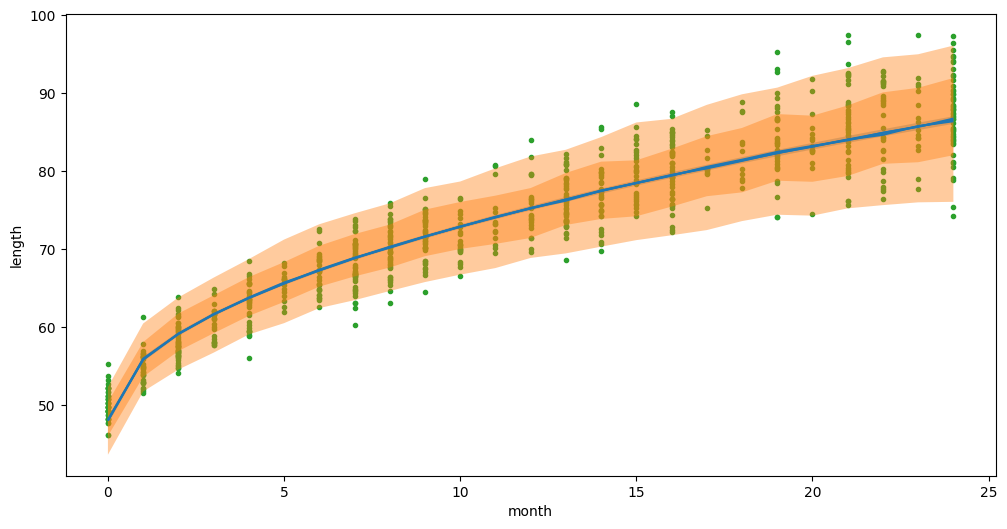

In [18]:
#there's more code here so I could plot two HDIs
_, ax = plt.subplots(sharey=True, sharex="col", figsize=(12, 6))
#mean line
bmb.interpret.plot_predictions(model_dis, idata_dis, "month", ax=ax, fig_kwargs={"color":"k"})
#94% HDI
bmb.interpret.plot_predictions(model_dis, idata_dis, "month", pps=True, ax=ax)
#65% HDI
ax_ = bmb.interpret.plot_predictions(model_dis, idata_dis, "month", pps=True, ax=ax, prob=0.65)
ax_[1][0].get_children()[5].set_facecolor('C1')

#raw data
ax.plot(babies.month, babies.length, "C2.", zorder=-3)

Same thing as before. Neat.

### Categorical variables versus Hierarchies

Let's get back to the action something new: creating a model with categorical variables and continuous variables. Sepcifically, one categorical and several continuous variables.

We'll also create a hierarchical regression with that same categorical variable, and discuss when to treat it as its own variable, and when to think of it as a hierarchy.